### Tutorial

<h3 class="no-toc" style="font-weight: bold;">sc-OTGM evaluation on CROP-Seq dataset</h3>

In [1]:
import numpy as np
import pandas as pd
import ast
import logging
from collections import Counter
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from src.dataloader.cropSeq import CropSeqLoader
from src.models.rank_sum_test import RankSumTestAnalyzer
from src.models.t_test import TTestAnalyzer
from utils.plot_perturbation_predictions import apply_gradient_background, plot_perturbations

In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()

<h3 class="no-toc" style="font-weight: bold;">Load differential expression summary</h3>

In [3]:
de_summary = pd.read_csv('../../../data/cropSeq/cropSeq_differential_expression_summary.csv')

In [4]:
gene_perturbed = "KIFAP3" 

<h3 class="no-toc" style="font-weight: bold;">Identify targeted and non-targeted (control) cell IDs for the experiment this gene is modified</h3>

In [5]:
def transform_barcodes(series):
    return series.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [6]:
de_summary['target_cell_barcodes'] = transform_barcodes(de_summary['target_cell_barcodes'])
de_summary['control_cell_barcodes'] = transform_barcodes(de_summary['control_cell_barcodes'])

In [7]:
target_cell_barcodes = de_summary[de_summary['gene_perturbed'] == gene_perturbed]["target_cell_barcodes"].explode().tolist()
control_cell_barcodes = de_summary[de_summary['gene_perturbed'] == gene_perturbed]["control_cell_barcodes"].explode().tolist()
logging.info("Target cell barcodes: %d", len(target_cell_barcodes))
logging.info("Control cell barcodes: %d", len(control_cell_barcodes))

2024-04-04 17:41:03,340 - INFO - Target cell barcodes: 100
2024-04-04 17:41:03,342 - INFO - Control cell barcodes: 368


<h3 class="no-toc" style="font-weight: bold;">Identify differentially expressed genes when this randomly selected gene is modified  </h3>

In [8]:
de_summary['genes_de'] = transform_barcodes(de_summary['genes_de'])
de_summary['genes_not_de'] = transform_barcodes(de_summary['genes_not_de'])

In [9]:
genes_de = de_summary[de_summary['gene_perturbed'] == gene_perturbed]["genes_de"].explode().tolist()
genes_not_de = de_summary[de_summary['gene_perturbed'] == gene_perturbed]["genes_not_de"].explode().tolist()
logging.info("Genes differentially expressed: %d", len(genes_de))
logging.info("Genes not differentially expressed: %d", len(genes_not_de))

2024-04-04 17:41:07,119 - INFO - Genes differentially expressed: 10
2024-04-04 17:41:07,121 - INFO - Genes not differentially expressed: 8157


<h3 class="no-toc" style="font-weight: bold;">Load CROP-Seq dataset</h3>

2024-04-04 17:41:07,134 - INFO - Reading dataset from ../../../data/cropSeq/CRISPRi_filtered_filtered_combined_normalized_selected.h5ad...
2024-04-04 17:41:08,036 - INFO - All columns: Index(['batch', 'gene', 'n_counts', 'n_genes', 'percent_mito', 'sgRNA'], dtype='object')


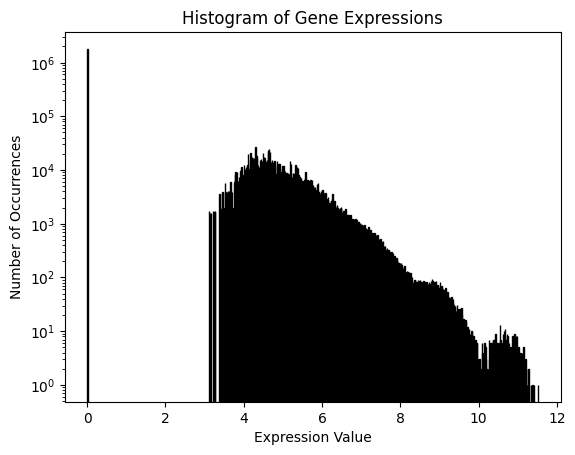

2024-04-04 17:41:11,002 - INFO - 
Initial Data Shape: (468, 8167)
2024-04-04 17:41:11,003 - INFO - ##################################################
2024-04-04 17:41:11,055 - INFO - Preprocessing Step 1: Remove cells with less than 200 genes.
2024-04-04 17:41:11,055 - INFO - Data Shape: (468, 8167)
2024-04-04 17:41:11,056 - INFO - ##################################################
2024-04-04 17:41:11,121 - INFO - Preprocessing Step 2: Remove genes present in less than 20 cells.
2024-04-04 17:41:11,122 - INFO - Data Shape: (468, 8086)
2024-04-04 17:41:11,122 - INFO - ##################################################
2024-04-04 17:41:11,207 - INFO - Preprocessing Step 3: Normalize data to 10000.0 counts per cell.
2024-04-04 17:41:11,208 - INFO - Data Shape: (468, 8086)
2024-04-04 17:41:11,208 - INFO - ##################################################
2024-04-04 17:41:11,487 - INFO - Preprocessing Step 4: Identify highly variable genes with 0.0125 < mean < 5 and dispersion > -2.
2024-0

Preprocessing Step 6: Retain only the highly variable genes.
Data Shape:  (468, 8045)
##################################################
Preprocessing Step 7: Scale the data to have zero mean and unit variance.
##################################################


In [10]:
loader = CropSeqLoader(path="../../../data/cropSeq/CRISPRi_filtered_filtered_combined_normalized_selected.h5ad",
                       target_cell_barcodes=target_cell_barcodes,
                       control_cell_barcodes=control_cell_barcodes)

logging.info("Shape of preprocessed data: %s", loader.adata.X.shape)
logging.info("Number of labels: %s", loader.adata.obs["label"].shape)
num_samples, _ = loader.adata.X.shape
num_labels = loader.adata.obs["label"].size

if num_samples != num_labels:
    raise ValueError(f"Mismatch in number of samples and labels: {num_samples} samples but {num_labels} labels.")

logging.info("Label distribution: %s", dict(Counter(loader.adata.obs["label"])))

In [11]:
loader.adata.var_names

Index(['AL645608.3', 'SAMD11', 'NOC2L', 'HES4', 'AGRN', 'SDF4', 'B3GALT6',
       'UBE2J2', 'ACAP3', 'PUSL1',
       ...
       'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6',
       'MT-CYB', 'AC011043.1', 'AC004556.1'],
      dtype='object', name='index', length=8045)

<h3 class="no-toc" style="font-weight: bold;">Calculate log2 fold change</h3>

Positive log2FC: If the log2FC value is positive, it means that the gene is overexpressed in the target group relative to the control group. The magnitude of the log2FC value indicates how many times the expression is doubled. For example, a log2FC of 1 means the gene expression is 2^1 = 2 times higher in the target group compared to the control group.

Negative log2FC: Conversely, if the log2FC value is negative, it means that the gene is underexpressed (or downregulated) in the target group relative to the control group. For instance, a log2FC of -1 would imply that the gene expression is 2^-1 = 0.5 times the expression in the target group, or that it's halved compared to the control group.

In [12]:
control_cells = loader.adata[loader.adata.obs['label'] == 0, :]
target_cells = loader.adata[loader.adata.obs['label'] == 1, :]

mean_expression_control = np.mean(control_cells[:, gene_perturbed].X)
mean_expression_target = np.mean(target_cells[:, gene_perturbed].X)

log2fc = np.log2(mean_expression_target + 1) - np.log2(mean_expression_control + 1)
log2fc

/var/folders/gm/70nw05h90ml61fsp0hzwby640000gn/T/ipykernel_66904/1468761918.py:7: RuntimeWarning: invalid value encountered in log2
  log2fc = np.log2(mean_expression_target + 1) - np.log2(mean_expression_control + 1)


nan

In [13]:
logging.info(control_cells.shape)
logging.info(target_cells.shape)

2024-04-04 17:41:26,100 - INFO - (368, 8045)
2024-04-04 17:41:26,102 - INFO - (100, 8045)


<h3 class="no-toc" style="font-weight: bold;">PCA reduction to subspace</h3>

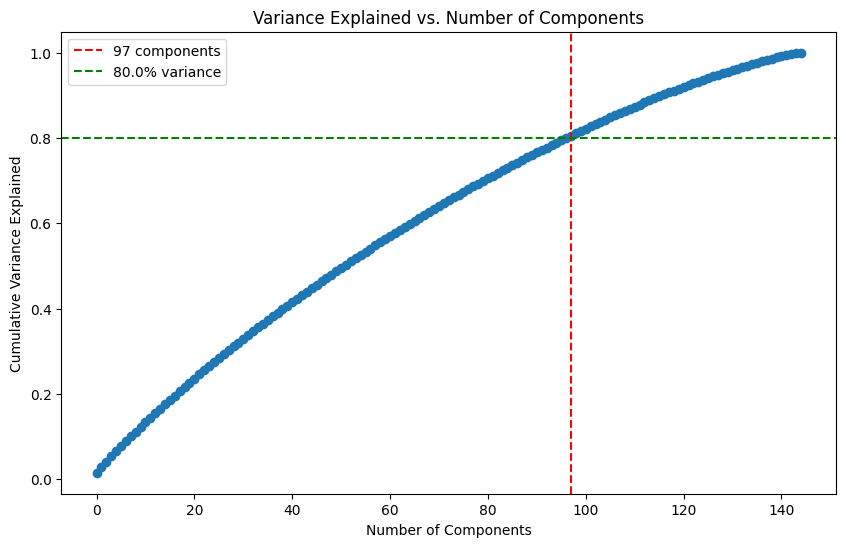

2024-04-04 17:41:26,684 - INFO - Shapes after PCA: (146, 97), (94, 97)


In [14]:
y = loader.adata.obs["label"]
X_train, X_test, y_train, y_test = train_test_split(loader.adata.X, y, test_size=0.20, random_state=42)

# Add y_train as a column to X_train
# Note: np.c_ concatenates along the second axis (like np.concatenate with axis=1)
train_data = np.c_[X_train, y_train]

# Separate majority and minority classes
mode_label = np.bincount(y_train).argmax()
is_majority = train_data[:, -1] == mode_label
is_minority = ~is_majority

majority_class = train_data[is_majority]
minority_class = train_data[is_minority]

# Downsample majority class
np.random.seed(42)  # For reproducibility
majority_downsampled_indices = np.random.choice(majority_class.shape[0], size=minority_class.shape[0], replace=False)
majority_downsampled = majority_class[majority_downsampled_indices]

# Combine minority class with downsampled majority class
balanced_data = np.vstack((majority_downsampled, minority_class))

# Shuffle the dataset to mix up the rows
np.random.shuffle(balanced_data)

# Separate the features and labels
X_train = balanced_data[:, :-1]
y_train = balanced_data[:, -1].astype(int)  # Ensure labels are integers if they were not already

pca = PCA(svd_solver='arpack')
pca.fit(X_train)

# Determine number of components to explain the desired variance
explained_variances = pca.explained_variance_ratio_
cumulative_variances = np.cumsum(explained_variances)
variance_threshold = 0.8
n_components = np.where(cumulative_variances >= variance_threshold)[0][0] + 1

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variances, marker='o', linestyle='--')
plt.title('Variance Explained vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.axvline(x=n_components, color='r', linestyle='--', label=f'{n_components} components')
plt.axhline(y=variance_threshold, color='g', linestyle='--', label=f'{variance_threshold * 100}% variance')
plt.legend()
plt.show()

# Apply PCA with desired number of components
pca = PCA(n_components=n_components, svd_solver='arpack')
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)
logging.info("Shapes after PCA: %s, %s", X_pca_train.shape, X_pca_test.shape)

<h3 class="no-toc" style="font-weight: bold;">Expectation-Maximization for the Gaussian mixture parameter estimation</h3>

In [15]:
n_clusters = len(np.unique(y))
initial_means = np.array([X_pca_train[y_train == i].mean(axis=0) for i in range(n_clusters)])
initial_covariances = np.array([np.cov(X_pca_train[y_train == i], rowvar=False) for i in range(n_clusters)])
epsilon = 1e-3
initial_covariances += np.eye(X_pca_train.shape[1]) * epsilon
initial_weights = np.array([(y_train == i).mean() for i in range(n_clusters)])

gmm = GaussianMixture(n_components=n_clusters,
                      means_init=initial_means,
                      precisions_init=np.linalg.inv(initial_covariances),
                      weights_init=initial_weights,
                      max_iter=10)
gmm.fit(X_pca_train)

GaussianMixture(max_iter=10,
                means_init=array([[ 0.96432378, -0.97830157, -1.90890943, -1.27121006,  1.47716437,
        -0.47755371,  0.95266837,  0.16238712, -0.45938605, -0.69043628,
         0.8307845 , -0.61081793, -1.00683925, -0.69963119, -0.49507785,
         1.15727226,  0.31023894,  0.24734396,  0.09604834,  1.1070279 ,
        -0.02069773,  0.11696117, -0.52585826, -0.28572671, -0.88617682,
         0.09651158, -0.48...
          2.51159772e+01, -2.04267364e+01,  1.88620246e+01],
        ...,
        [-3.27796738e+01, -1.45690759e+01,  2.51159772e+01, ...,
          2.50195341e+02, -8.30786247e+01, -3.58586890e+01],
        [ 6.35618114e+00, -3.09909483e-02, -2.04267364e+01, ...,
         -8.30786247e+01,  5.88024813e+01, -1.09271496e+00],
        [-4.62870471e+01,  9.83748138e+00,  1.88620246e+01, ...,
         -3.58586890e+01, -1.09271496e+00,  1.50632474e+02]]]),
                weights_init=array([0.5, 0.5]))

<h3 class="no-toc" style="font-weight: bold;">Prediction using the trained GMM model</h3>

In [16]:
# Predict the cluster assignments for both test and train sets
gmm_labels = gmm.predict(X_pca_test)
gmm_labels_train = gmm.predict(X_pca_train)

# Efficient function to map clusters to labels
def map_clusters_to_labels(gmm_labels, gmm_model, initial_means):
    matching = {}
    for i, final_mean in enumerate(gmm_model.means_):
        distances = np.linalg.norm(initial_means - final_mean, axis=1)
        closest_label = np.argmin(distances)
        matching[i] = closest_label
    return np.array([matching[label] for label in gmm_labels])

# Map the predicted cluster assignments to the corresponding labels
y_pred = map_clusters_to_labels(gmm_labels, gmm, initial_means)
y_pred_train = map_clusters_to_labels(gmm_labels_train, gmm, initial_means)

<h3 class="no-toc" style="font-weight: bold;">Evaluation on both train and test sets</h3>

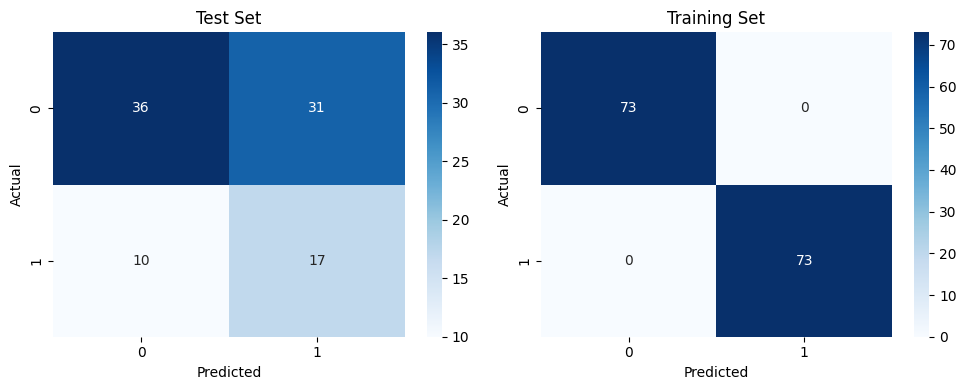

2024-04-04 17:41:27,268 - INFO - Confusion Matrix on Test Set (GMM) - Accuracy: 0.5638
2024-04-04 17:41:27,269 - INFO - Confusion Matrix on Train Set (GMM) - Accuracy: 1.0000


In [17]:
accuracy_test = accuracy_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)

accuracy_train = accuracy_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)

cm_test = confusion_matrix(y_test, y_pred)
cm_train = confusion_matrix(y_train, y_pred_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", ax=axs[0])
axs[0].set_title('Test Set')
axs[0].set_ylabel('Actual', fontsize=10)
axs[0].set_xlabel('Predicted', fontsize=10)

sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=axs[1])
axs[1].set_title('Training Set')
axs[1].set_ylabel('Actual', fontsize=10)
axs[1].set_xlabel('Predicted', fontsize=10)

plt.tight_layout()
plt.show()

logger.info(f'Confusion Matrix on Test Set (GMM) - Accuracy: {accuracy_test:.4f}')
logger.info(f'Confusion Matrix on Train Set (GMM) - Accuracy: {accuracy_train:.4f}')

<h3 class="no-toc" style="font-weight: bold;">Perturbation modeling</h3>

In [18]:
unperturbed_cluster = 0
perturbed_cluster = 1

In [19]:
def match_cluster_to_label(gmm, cluster_id, initial_means):
    """
    Match a cluster to a label based on the proximity of the initial and final mean vectors.

    Args:
        gmm: Pretrained gmm model
        cluster_id (int): Index of the cluster to be matched.
        initial_means (np.array): Array containing the initial mean vectors for each cluster.

    Returns:
        int: The matched label index.
    """
    initial_mean = initial_means[cluster_id]
    distances = np.linalg.norm(gmm.means_ - initial_mean, axis=1)
    matched_cluster = np.argmin(distances)
    return matched_cluster

In [20]:
unperturbed_cluster_matched = match_cluster_to_label(gmm, unperturbed_cluster, initial_means)
perturbed_cluster_matched = match_cluster_to_label(gmm, perturbed_cluster, initial_means)

<h3 class="no-toc" style="font-weight: bold;">Cross-covariance estimation with MCMC (Gibbs Sampling)</h3>

In [21]:
def get_non_zero_density_bounds(
            cov: np.ndarray,
            point: np.ndarray,
            direction: np.ndarray,
            confidence: float = 0.95,
    ) -> tuple:
        """
        Calculate the bounds for non-zero density in a specified direction.

        Args:
            cov (np.ndarray): Covariance matrix of the distribution.
            point (np.ndarray): Current point in the distribution.
            direction (np.ndarray): Direction vector for calculating bounds.
            confidence (float, optional): Confidence level for the bounds.
                Default is 0.95.

        Returns:
            tuple: A tuple of lower and upper bounds.
        """
        # Normalize the direction vector
        direction_normalized = direction / np.linalg.norm(direction)

        # Project the point onto the direction
        point_projection = np.dot(point, direction_normalized)

        # Calculate the variance of the projection
        variance_projection = np.dot(
            direction_normalized.T, np.dot(cov, direction_normalized)
        )
        # Calculate the standard deviation of the projection
        std_deviation = np.sqrt(variance_projection)
        # Find the z-scores for the specified confidence interval
        z_score = norm.ppf((1 + confidence) / 2)

        # Calculate the bounds
        lower_bound = point_projection - z_score * std_deviation
        upper_bound = point_projection + z_score * std_deviation
        return lower_bound, upper_bound
    
def get_cross_covariance_by_hit_and_run_gibbs_sampling(gmm, 
                                                       unperturbed_cluster_matched, 
                                                       perturbed_cluster_matched, 
                                                       num_iterations: int = 1000) -> np.ndarray:
        """
        Estimate the cross-covariance matrix using Hit-and-Run Gibbs Sampling.

        Args:
            num_iterations (int): Number of iterations to perform.

        Returns:
            np.ndarray: Estimated cross-covariance matrix.
        """
        # Get means and covariances for each cluster
        means_x = gmm.means_[unperturbed_cluster_matched]
        cov_x = gmm.covariances_[unperturbed_cluster_matched]
        means_y = gmm.means_[perturbed_cluster_matched]
        cov_y = gmm.covariances_[perturbed_cluster_matched]

        # Initialize starting points
        x_current = np.random.multivariate_normal(means_x, cov_x)
        y_current = np.random.multivariate_normal(means_y, cov_y)

        # Initialize cross_covariance
        cross_covariance = np.zeros_like(cov_x)
        np.fill_diagonal(cross_covariance, 1e-4)

        for i in range(1, num_iterations + 1):
            # Hit-and-Run sampling for X
            direction_x = np.random.randn(len(means_x))
            lb_x, ub_x = get_non_zero_density_bounds(cov_x, x_current, direction_x)
            x_current = np.random.uniform(lb_x, ub_x)

            # Hit-and-Run sampling for Y
            direction_y = np.random.randn(len(means_y))
            lb_y, ub_y = get_non_zero_density_bounds(cov_y, y_current, direction_y)
            y_current = np.random.uniform(lb_y, ub_y)

            # Sequential update on cross-covariance matrix
            deviation_x = x_current - means_x
            deviation_y = y_current - means_y
            cross_covariance = (i / (i + 1)) * cross_covariance + (
                    i / (i + 1) ** 2
            ) * np.outer(deviation_x, deviation_y)

        return cross_covariance

In [22]:
def make_positive_semidefinite(matrix):
        """
        Converts a given square matrix into a positive semidefinite matrix.

        This method computes the eigenvalues and eigenvectors of the input matrix using
        the Hermitian eigenvalue decomposition. It then adjusts any negative eigenvalues to 
        a very small positive value (1e-99) to ensure that the resulting matrix is positive 
        semidefinite. The adjusted eigenvalues are used to reconstruct a positive semidefinite 
        matrix using the original eigenvectors.

        Args:
            matrix (numpy.ndarray): A square numpy array representing the matrix to be converted
                into a positive semidefinite matrix.
        
        Returns:
            np.ndarray: A positive semidefinite matrix derived from the input matrix.
        """
        eigenvalues, eigenvectors = np.linalg.eigh(matrix)
        eigenvalues[eigenvalues < 0] = 1e-99  # Set any small negative eigenvalues to a small positive value
        return eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T

def additive_parameters(gmm, unperturbed_cluster_matched, perturbed_cluster_matched):
        """
        Find the parameters of the additive Gaussian noise between two clusters.

        Returns:
            tuple: Mean and covariance matrix of the additive Gaussian noise.
        """
        # Mean of the additive Gaussian noise
        perturb_mean = gmm.means_[perturbed_cluster_matched] - gmm.means_[unperturbed_cluster_matched]

        np.set_printoptions(threshold=np.inf)
        cross_cov = get_cross_covariance_by_hit_and_run_gibbs_sampling(gmm, 
                                                                       unperturbed_cluster_matched, 
                                                                       perturbed_cluster_matched)

        perturb_cov = (
            gmm.covariances_[unperturbed_cluster_matched]
            + gmm.covariances_[perturbed_cluster_matched]
            - 2 * cross_cov
        )
        perturb_cov = make_positive_semidefinite(perturb_cov)

        return perturb_mean, perturb_cov

In [23]:
def sample_from_perturbation(gmm, unperturbed_cluster_matched, perturbed_cluster_matched, n_samples=10000):
    """
    Sample from the perturbation distribution using Monte Carlo.

    Args:
        gmm: Pretrained gmm model
        unperturbed_cluster_matched (int): Index of the starting cluster from which the perturbation originates.
        perturbed_cluster_matched (int): Index of the target cluster where the perturbation is applied.
        num_samples (int): Number of Monte Carlo samples to simulate perturbation distribution. 
    """
    # Extract mean and covariance of the perturbation distribution
    perturbation_mean, perturbation_cov = additive_parameters(gmm, unperturbed_cluster_matched, perturbed_cluster_matched)

    # Sample using the multivariate normal distribution
    def make_positive_semidefinite(matrix):
        eigenvalues, eigenvectors = np.linalg.eigh(matrix)
        eigenvalues[eigenvalues < 0] = 1e-99  # Set any small negative eigenvalues to a small positive value
        return eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T

    perturbation_cov = make_positive_semidefinite(perturbation_cov)
    samples = np.random.multivariate_normal(perturbation_mean, perturbation_cov, n_samples)
    samples = pca.inverse_transform(samples)
    
    # Return mean and standard deviation for each gene
    gene_perturbation_means = np.mean(samples, axis=0)  # magnitude of up/down regulation in perturbation
    gene_perturbation_std_devs = np.std(samples, axis=0)  # uncertainty (confidence) in estimates

    return gene_perturbation_means, gene_perturbation_std_devs

In [24]:
# Get the parameters of the additive Gaussian noise (perturbation) between clusters cs and ce
gene_perturbation_means, gene_perturbation_std_devs = sample_from_perturbation(gmm, unperturbed_cluster_matched, perturbed_cluster_matched)

<h3 class="no-toc" style="font-weight: bold;">Visualization</h3>

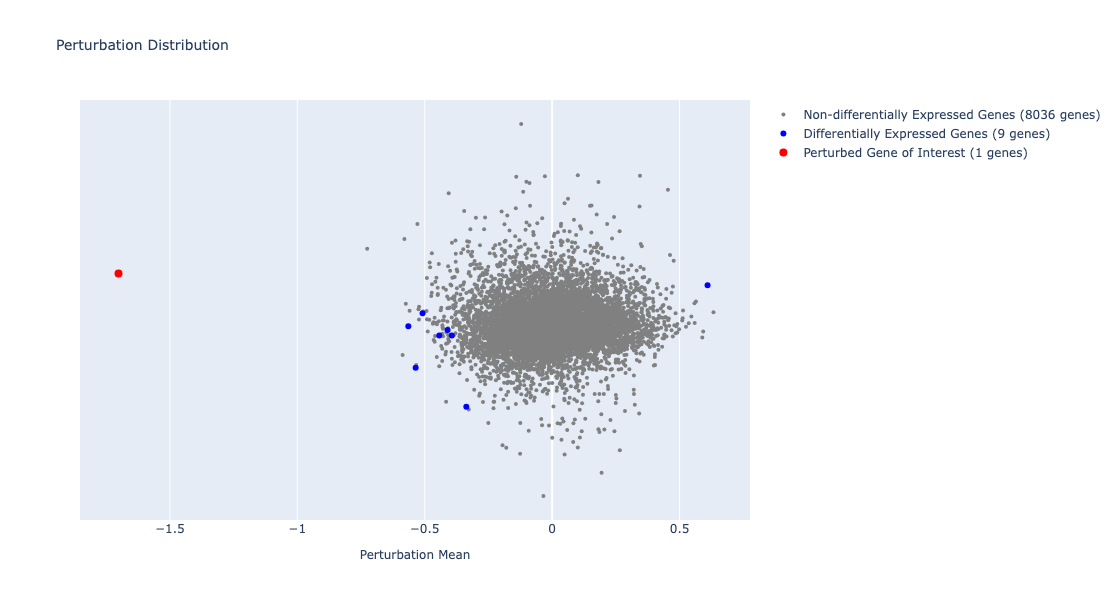

In [25]:
gene_names = loader.adata.var_names

# Create masks for perturbed gene, differentially expressed genes and non-differentially expressed genes
red_mask = np.isin(gene_names, gene_perturbed)  # perturbed gene
blue_mask = np.isin(gene_names, genes_de)  # differentially expressed genes
gray_mask = ~(red_mask | blue_mask)  # non-differentially expressed genes

# First, create a scatter plot for the non-differentially expressed genes
fig = go.Figure(data=go.Scatter(
    x=gene_perturbation_means[gray_mask],
    y=gene_perturbation_std_devs[gray_mask],
    mode='markers',
    marker=dict(size=4, color='gray'),
    text=gene_names[gray_mask],
    hoverlabel=dict(font=dict(size=10)),  # Adjust the font size here
    name="Non-differentially Expressed Genes (%i genes)" % np.sum(gray_mask)
))

# Then, create a scatter plot for differentially expressed genes
fig.add_trace(go.Scatter(
    x=gene_perturbation_means[blue_mask],
    y=gene_perturbation_std_devs[blue_mask],
    mode='markers',
    marker=dict(size=6, color='blue'),
    text=gene_names[blue_mask],
    hoverlabel=dict(font=dict(size=10)),  # Adjust the font size here
    name="Differentially Expressed Genes (%i genes)" % np.sum(blue_mask)
))

# Finally, create a scatter plot for the genes of interest
fig.add_trace(go.Scatter(
    x=gene_perturbation_means[red_mask],
    y=gene_perturbation_std_devs[red_mask],
    mode='markers',
    marker=dict(size=8, color='red'),
    text=gene_names[red_mask],
    hoverlabel=dict(font=dict(size=10)),  # Adjust the font size here
    name="Perturbed Gene of Interest (%i genes)" % np.sum(red_mask)
))

fig.update_layout(
    title={
        'text': "Perturbation Distribution",
        'font': {
            'size': 14  # adjust this for title font size
        }
    },
    xaxis_title="Perturbation Mean",
    xaxis={
        'title': {
            'text': "Perturbation Mean",
            'font': {
                'size': 12  # adjust this for x-axis title font size
            }
        }
    },
    yaxis=dict(
        tickvals=[]  # This hides the y-axis tick labels
    ),
    legend={
        'font': {
            'size': 12
        }
    },
    width=1000, 
    height=600,
    hovermode="closest"  # hover closest point by default
)

fig.show()

In [26]:
# Create the DataFrame
ranked_genes = pd.DataFrame({
               'Gene': gene_names,
               'Perturbation Mean': gene_perturbation_means,
               'Uncertainty': gene_perturbation_std_devs
})

# Sorting the DataFrame based on the magnitude of perturbation mean
ranked_genes = ranked_genes.reindex(ranked_genes['Perturbation Mean'].sort_values(ascending=True).index)

# Reset the index to get the rank
ranked_genes = ranked_genes.reset_index(drop=True)

# Display the sorted DataFrame
ranked_genes.head(10)

Gene  Perturbation Mean  Uncertainty
0  KIFAP3          -1.701779     1.589473
1   OLFM1          -0.725966     1.708989
2    COG4          -0.586805     1.196737
3  PTP4A2          -0.579819     1.755967
4  CAMTA1          -0.574301     1.443910
5  EXOSC5          -0.564385     1.335534
6     NCL          -0.559531     1.410105
7   TADA1          -0.535705     1.135239
8  TRIM23          -0.533489     1.147761
9    CHD4          -0.528922     1.828827

In [27]:
gene_to_find = gene_perturbed  # Replace with the gene you are looking for
gene_rank = ranked_genes.index[ranked_genes['Gene'] == gene_to_find].tolist()[0]  # Get the first (or only) position

logging.info("Rank of %s: %d", gene_to_find, gene_rank + 1)  # Adding 1 because index is 0-based

2024-04-04 17:41:29,653 - INFO - Rank of KIFAP3: 1


items_to_remove = ['ICMT', 'CRIM1', 'SGK3', 'CCND1', 'PRSS23', 'DLAT', 'FABP7']
genes_de = [gene for gene in genes_de if gene not in items_to_remove]

<h3 class="no-toc" style="font-weight: bold;">In silico perturbation response prediction</h3>

In [28]:
control_df = pd.DataFrame(control_cells.X, columns=gene_names)
target_df = pd.DataFrame(target_cells.X, columns=gene_names)
items_to_remove = ['CENPK']
genes_de = [gene for gene in genes_de if gene not in items_to_remove]

In [29]:
true_delta = target_df[genes_de].mean(axis=0) - control_df[genes_de].mean(axis=0)
true_delta_df = true_delta.to_frame(name="Mean Shift").reset_index().rename(columns={'index': 'Gene'})

styled_df = true_delta_df.style.apply(apply_gradient_background, subset=['Mean Shift'], min_color='blue', max_color='orange', axis=0)

In [30]:
styled_df

In [31]:
gene_index_dict = {}
for gene in genes_de:
    try:
        index = loader.adata.var_names.get_loc(gene)
        gene_index_dict[gene] = index
    except KeyError:
        # Handle missing genes, for example, by setting the index to None or skipping
        gene_index_dict[gene] = None  # Or simply continue without adding to the dictionary

gene_index_dict

{'TADA1': 588,
 'KIFAP3': 600,
 'FLNA': 3567,
 'MYL6B': 5120,
 'AP1G1': 6349,
 'EXOSC5': 7586,
 'CADM4': 7604,
 'SYNJ1': 7973,
 'RRP1': 8010}

In [32]:
perturbation_mean, perturbation_cov = additive_parameters(gmm, unperturbed_cluster_matched, perturbed_cluster_matched)
original_cov = pca.components_.T @ (perturbation_cov * pca.explained_variance_[:, np.newaxis]) @ pca.components_
# original_cov = pca.components_.T @ perturbation_cov @ pca.components_
original_cov.shape

(8045, 8045)

In [33]:
def calculate_delta_xj(covariance_matrix, i, j, delta_xi):
    """
    Calculate the change in xj (delta xj) based on the covariance matrix, indices i, j, and change in xi (delta xi).

    :param covariance_matrix: The covariance matrix (2D numpy array).
    :param i: Index i (int).
    :param j: Index j (int).
    :param delta_xi: Change in xi (float).
    :return: Change in xj (float).
    """
    cov_xi_xj = covariance_matrix[j, i]  # Covariance between xj and xi
    var_xi = covariance_matrix[i, i]  # Variance of xi
    
    # Calculate the regression coefficient of xj on xi
    beta_ji = cov_xi_xj / var_xi
    
    # Calculate and return the change in xj
    delta_xj = beta_ji * delta_xi
    return delta_xj

2024-04-04 17:41:30,688 - INFO - sc-OTGM linear approximation of perturbation prediction: Perturbation in 'KIFAP3' with intensity -1.6403095722198486 results in a predicted change in expression as follows,


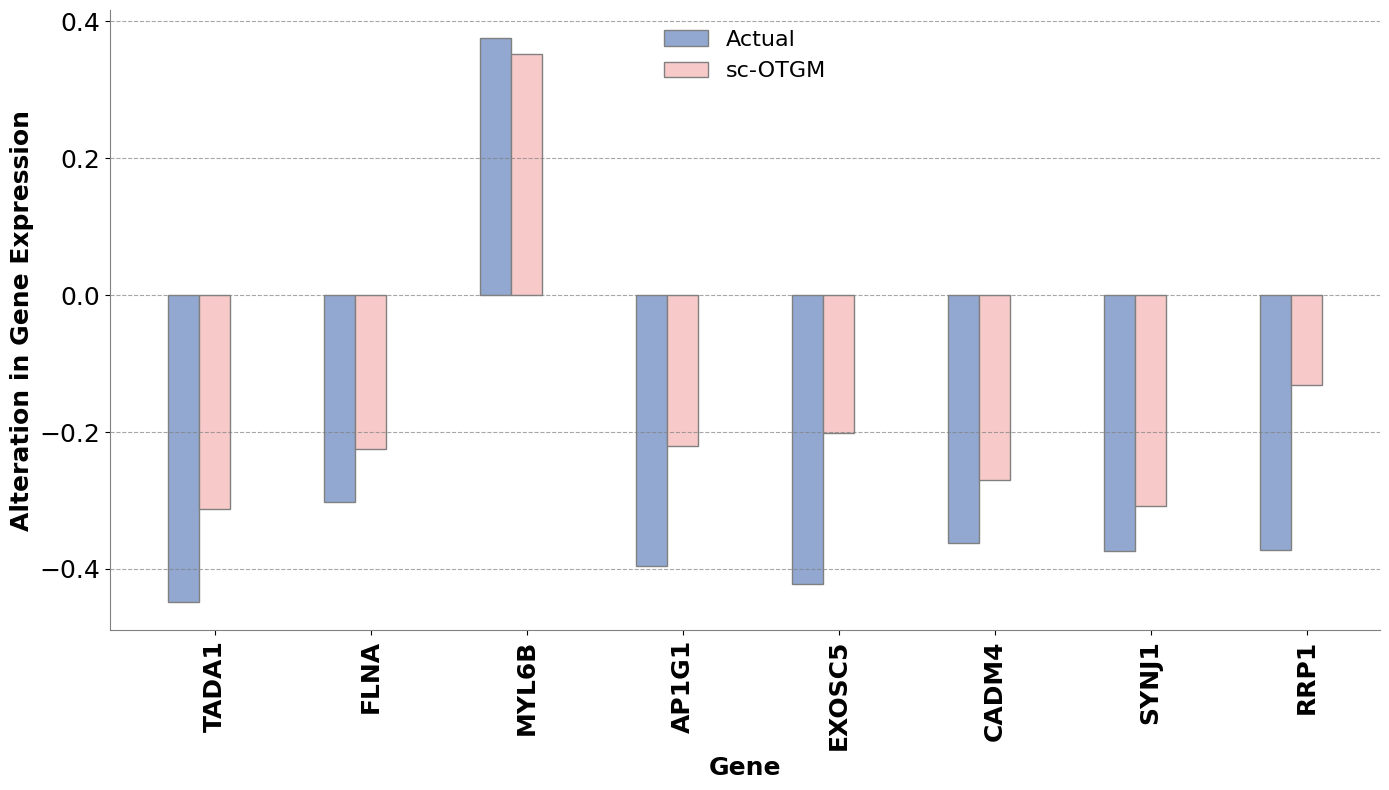

In [34]:
# Change in the expression of targeted gene
i = gene_index_dict[gene_perturbed]
delta_xi = true_delta_df[true_delta_df["Gene"]==gene_perturbed]['Mean Shift'].iloc[0].astype(float)
logging.info(
            f"sc-OTGM linear approximation of perturbation prediction: Perturbation in '{gene_perturbed}' "
            f"with intensity {delta_xi} "
            f"results in a predicted change in expression as follows,")

# change in the expression of other genes
true_delta_df = true_delta_df[true_delta_df["Gene"] != gene_perturbed]
genes = true_delta_df['Gene'].tolist()
true_shift = true_delta_df['Mean Shift'].tolist()

predicted_response = [calculate_delta_xj(original_cov, i, gene_index_dict[gene], delta_xi) for gene in genes]
plot_perturbations(genes, true_shift, predicted_response)

In [35]:
rmse = np.sqrt(((np.array(true_shift) - np.array(predicted_response)) ** 2).mean())
logging.info("RMSE: %f", rmse)

2024-04-04 17:41:31,600 - INFO - RMSE: 0.148472


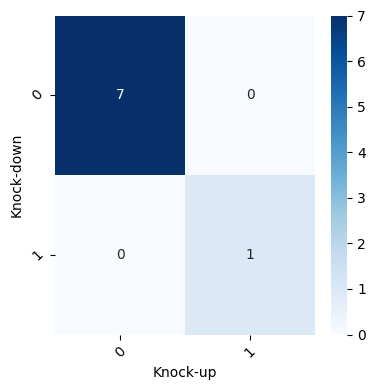

2024-04-04 17:41:31,776 - INFO - Confusion Matrix on Test Set (GMM) - Accuracy: 1.0000


In [36]:
true_classes = np.where(np.array(true_shift) >= 0, 1, 0)
predicted_classes = np.where(np.array(predicted_response) >= 0, 1, 0)

accuracy = accuracy_score(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

plt.figure(figsize=(4, 4))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, fontsize=10)

plt.ylabel('Knock-down', fontsize=10)
plt.xlabel('Knock-up', fontsize=10)
plt.tight_layout()  
plt.show()

logger.info(f'Confusion Matrix on Test Set (GMM) - Accuracy: {accuracy:.4f}')